## Projet numérique : lignes de niveau
## Arnaud Mondon, Nicolas Hue


On importe les modules nécessaires, et on définit les fonctions d'exemple.

In [15]:
!pip install autograd
import autograd as ag
from autograd import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = lambda x,y : x**2+y**2
g = lambda x,y : 2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))

On définit le carré unité comme le carré ([0,1],[0,1]).

## Contour simple

On définit d'abord une fonction qui calcule le gradient de la fonction f au point (x,y), en utilisant le module autograd.

In [3]:
def grad_f(f,x,y): #calcul du gradient de f en (x,y)
    a,b=float(x),float(y)
    gradient=ag.grad
    return np.array([gradient(f,0)(a,b),gradient(f,1)(a,b)])

La fonction **find_seed** permet de déterminer une approximation d'un point du segment [(0,0),(0,1)] en lequel f vaut c, en effectuant une recherche par dichotomie. On est certain de trouver un antécédent à c sur le côté gauche si c est compris entre f(0,0) et f(0,1) car f est continue.

In [4]:
def find_seed(f,c=0,eps=2**(-26)): #dichotomie pour calculer le point de départ
    
    if (f(0,0)-c)*(f(0,1)-c)>0:
        return None
    
    else :
        a=0
        b=1
        delta=b-a
        
        while delta > eps :
            d=(a+b)/2
            
            if (f(0,a)-c)*(f(0,d)-c)>0:
                a=d
            
            else :
                b=d
            
            delta=b-a
        
        return (a+b)/2

On définit également une fonction qui calcule la norme euclidienne d'un vecteur de R².

In [5]:
def norme(vect):#calcul de distance
    return np.sqrt(vect[0]**2+vect[1]**2)

La fonction **calcul_suivant** détermine les coordonnées du prochain point de la ligne de niveau de f. Pour cela, on calcule le gradient de f, et on se déplace d'un vecteur de norme delta, orthogonal au gradient.
En effet, le gradient de f est orthogonal à ses lignes de niveau : le vecteur orthogonal choisi est alors colinéaire à la tangente de la ligne de niveau au point (x,y). La ligne de niveau peut alors être approximée au premier ordre en delta par ce vecteur.
La direction de ce vecteur (orienté de + ou - 90° par rapport au gradient) peut être précisée, ce qui permet de choisir dans quel sens parcourir la ligne de niveau. On a ajouté cette fonctionnalité car sans elle, le programme pouvait directement sortir du carré unité et donc ne rien tracer.

In [6]:
def calcul_suivant(f,x,y,delta,direc=1):#calcul du point approché suivant de la ligne de niveau à partir de (x,y)
    gfx, gfy=grad_f(f,x,y)
    ortho = np.array([-gfy,gfx])
    ortho = ortho*delta / norme(ortho)*direc
    
    return x+ortho[0],y+ortho[1]

La fonction **simple_contour** permet de tracer une ligne de niveau de valeur c de f sur le carré unité, en partant d'un point sur le côté gauche du carré et en renvoyant les listes des abscisses et des ordonnées des points de la ligne.
Pour cela, on détermine le point de départ de la ligne de niveau grâce à la fonction **find_seed**.

Si un tel point est trouvé, on effectue un premier test afin de déterminer dans quel direction la ligne de niveau doit être suivie pour rester dans le carré élémentaire.
Une fois cette direction trouvée, on calcule de manière itérative les coordonnées des points de la ligne de niveau grâce à la fonction **calcul_suivant**, en s'arrêtant dès qu'un des points sort du carré élémentaire.

In [7]:
def simple_contour(f,c=0,delta=0.01):#renvoie la liste des points d'une ligne de niveau de valeur c pour le carré unité
    x=0
    y=find_seed(f,c)
    lx=[]
    ly=[]
    
    if y==None :
        return [],[]
    
    else :
        x_test,y_test=calcul_suivant(f,x,y,delta)
        if x_test>=0 and x_test<=1 and y_test>=0 and y_test<=1 :#permet de choisr le bon sens de la ligne de niveau (pour entrer dans le carré souhaité)
            direc = 1
        else :
            direc = -1
        i=0
        while x>=0 and x<=1 and y>=0 and y<=1:
            lx.append(x)
            ly.append(y)
            x,y=calcul_suivant(f,x,y,delta,direc)
            i+=1
        return lx,ly

On fait un test de notre programme avec la fonction quadratique f, et on affiche le résultat.

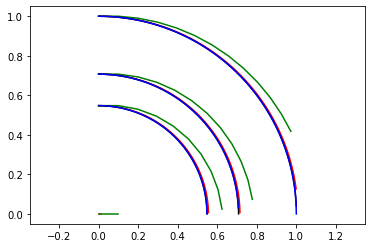

In [44]:
for i in [0,0.3,0.5,1]:

    X,Y= simple_contour(f,c=i,delta=0.01)
    X1,Y1=simple_contour(f,c=i,delta=0.1)
    X2,Y2=simple_contour(f,c=i,delta=0.001)
    # affiche les lignes de niveau obtenues avec notre fonction pour différentes valeurs de delta
    plt.plot(X,Y,"r") #rouge : delta = 0.01
    plt.plot(X1,Y1,"g") #vert : delta = 0.1
    plt.plot(X2,Y2,"k") #noir : delta = 0.001
    
    a=np.linspace(0,np.sqrt(i),1000)
    plt.plot(a,np.sqrt(i-a**2),'b') # affiche les lignes de niveau théoriques en bleu

plt.axis('equal')
plt.show()

On remarque premièrement que l'erreur s'accumule le long d'une ligne de niveau, du fait de la méthode itérative employée.
Cependant, cette erreur devient négligeable lorsque delta est suffisament petit.

Ainsi, pour obtenir une ligne de niveau cohérente, il faut que delta soit petit ou que la longueur de la ligne de niveau soit faible (cela sera rendu possible par le découpage du domaine en carrés plus petits).

# Contour Complexe

Maintenant que nous avons réalisé une fonction qui trace une ligne de niveau pour un carré unitaire, il faut étendre cette fonction à tout rectangle.

 Pour cela on réalise un découpage de ce rectangle en carrés de tailles quelconques puis on transforme f (avec déplacement, dilatation et rotation) afin de lui appliquer la fonction contour réalisée ci-dessus.

Dans un premier temps il faut définir une nouvelle fonction à partir de la restriction de f sur l'ensemble [x1,x2],[y1,y2]. Cette fonction sera alors définie sur le carré unité.

In [8]:
def f_carre(f,x1,x2,y1,y2):# transformation de la fonction en une fonction définie sur le carré unité
    nouv_f = lambda x,y : f(x1+x*(x2-x1),y1+y*(y2-y1))
    return nouv_f

La fonction **simple_contour** cherche uniquement un départ d'une ligne de niveau sur le bord gauche. Afin de rendre notre réprésentation des lignes de niveau plus complète, il convient de faire cette recherche sur chacun des bords. Nous réalisons donc cela en réutilisant la fonction **find_seed** définie dans la première partie sur la fonction f renvoyée par **f_carre** et en lui appliquant des symétries avec **f_symetrie**.

In [9]:
def f_symetrie(nouv_f,bord):#fait une rotation de la fonction pour pouvoir partir du bord gauche
    if bord == 'g' :
        return nouv_f
    if bord == 'b' :
        return lambda x,y : nouv_f(y,x)
    if bord == 'd':
        return lambda x,y : nouv_f(1-x,y)
    if bord == 'h':
        return lambda x,y : nouv_f(1-y,1-x)

On définit alors la fonction sur laquelle on va appliquer **simple_contour** (après transformation et rotation).

In [10]:
def f_transformee(f,x1,x2,y1,y2,bord):# renvoie la fonction après contraction/déplacement/rotation
    f_inter=f_carre(f,x1,x2,y1,y2)
    f_finale=f_symetrie(f_inter,bord)
    return f_finale

Pour un carré [x1,x2],[y1,y2] on définit quatre nouvelles fonctions (une pour chaque bord et on applique **simple_contour** qui nous renverra de 0 à 4 lignes de niveau . On applique ensuite les transformations inverses (rotation, dillatation, déplacement) aux points renvoyés.

In [11]:
def contour_carre(f,c,delta,x1,x2,y1,y2):# renvoie les lignes de niveau sur un carré quelconque à partir de chacun des bords
    X,Y=[],[]
    for bord in {'g','d','b','h'}:
        f_transfo=f_transformee(f,x1,x2,y1,y2,bord)
        lx,ly=simple_contour(f_transfo,c,delta)
        if lx == []:
            continue
        lx,ly=np.array(lx),np.array(ly)
        if bord == 'b':
            lx,ly=ly,lx

        elif bord == 'd':
            lx=1-lx
        
        elif bord =='h':
            lx,ly=1-ly,1-lx
        
        lx = lx*(x2-x1)+x1
        ly = ly*(y2-y1)+y1
        lx,ly=list(lx),list(ly)
        X.append(lx)
        Y.append(ly)
    return X,Y

Il suffit maintenant d'appliquer cette fonction pour chacun des carrés.

In [12]:
def contour(f,c=0.0,xc=[0.0,1.0],yc=[0.0,1.0],delta=0.01):#renvoie les lignes de niveau pour une rectangle quelconque à partir de subdivision en carrés élémentaires
    n=len(xc)
    m=len(yc)
    X,Y=[],[]
    for j in range(m-1):#ligne
        for i in range (n-1):#colonne
            x,y=contour_carre(f,c,delta,xc[i],xc[i+1],yc[j],yc[j+1])
            X+=x
            Y+=y

    return X,Y

Pour vérifier le fonctionnement de nos fonctions nous les appliquons à la fonction g donnée en exemple et traçons quelques unes de ses lignes de niveau.

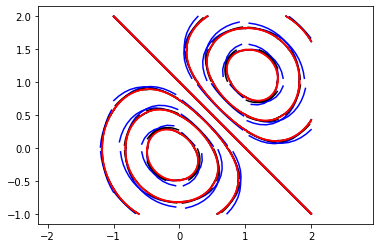

In [53]:
for i in [-1.5,-1,-0.5,0,0.5,1,1.5]:

    #on affiche les lignes de niveau pour des deltas différents
    X,Y= contour(g,c=i,xc=[-2,-1,0,1,2],yc=[-1,0,1,2],delta=0.01)
    X1,Y1= contour(g,c=i,xc=[-2,-1,0,1,2],yc=[-1,0,1,2],delta=0.1)
    X2,Y2= contour(g,c=i,xc=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2],yc=[-1,-0.5,0,0.5,1,1.5,2],delta=0.1)
    
    for x,y in zip(X1,Y1): # bleu : delta = 0.1
        plt.plot(x,y,"b")
    for x,y in zip(X2,Y2): #noir : delta = 0.1 mais carrés de taille 1/2
        plt.plot(x,y,"k")
    for x,y in zip(X,Y): #rouge : delta = 0.01
        plt.plot(x,y,"r")

plt.axis('equal') 
plt.show()

On voit que pour ne pas avoir de discontinuité, il faut prendre delta suffisament petit. Le découpage en carrés de petites tailles permet de prendre en compte des lignes de niveau qui ne coupent pas les bords du domaine et limite la propagation d'erreur.